# Daten importieren
*Datenquelle: [https://www.kaggle.com/datasets/samuelcortinhas/time-series-practice-dataset](https://www.kaggle.com/datasets/samuelcortinhas/time-series-practice-dataset)*

In [1]:
import pandas as pd

df = pd.read_csv("store_product_data_1.csv", parse_dates=["Date"], index_col="Date")
df = df.asfreq('D')
df

,number_sold
Date,
2013-01-01,841
2013-01-02,838
2013-01-03,840
2013-01-04,822
2013-01-05,871
...,...
2016-04-14,881
2016-04-15,877
2016-04-16,895


# Daten visualisieren

<Axes: xlabel='Date', ylabel='number_sold'>

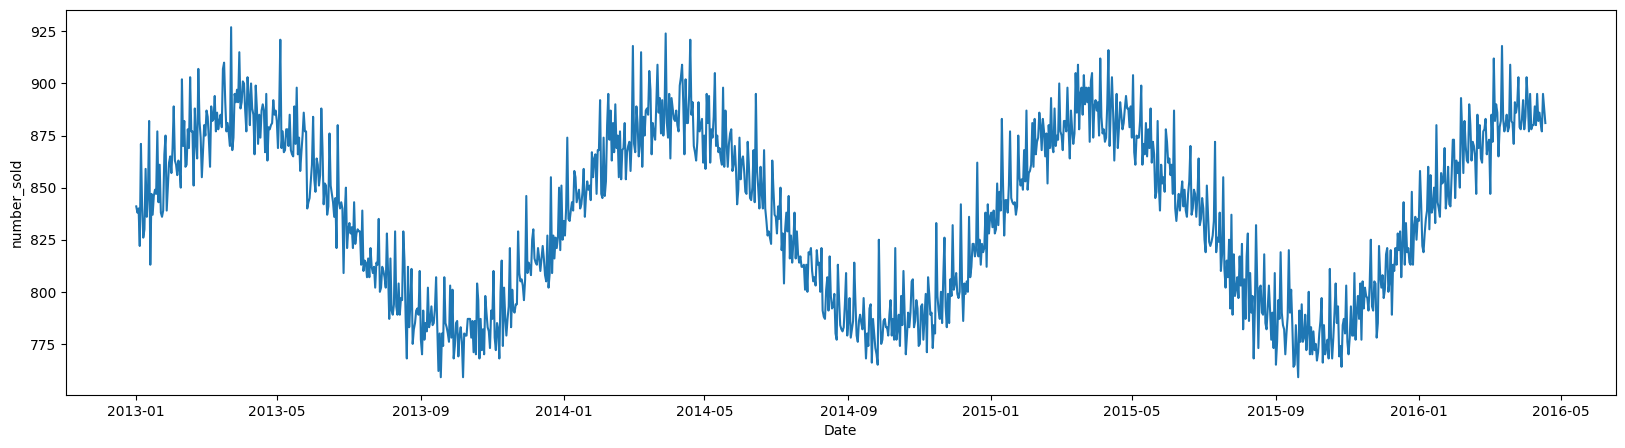

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
sns.lineplot(x=df.index, y=df["number_sold"])

Text(0.5, 1.0, 'Weekly Plot')

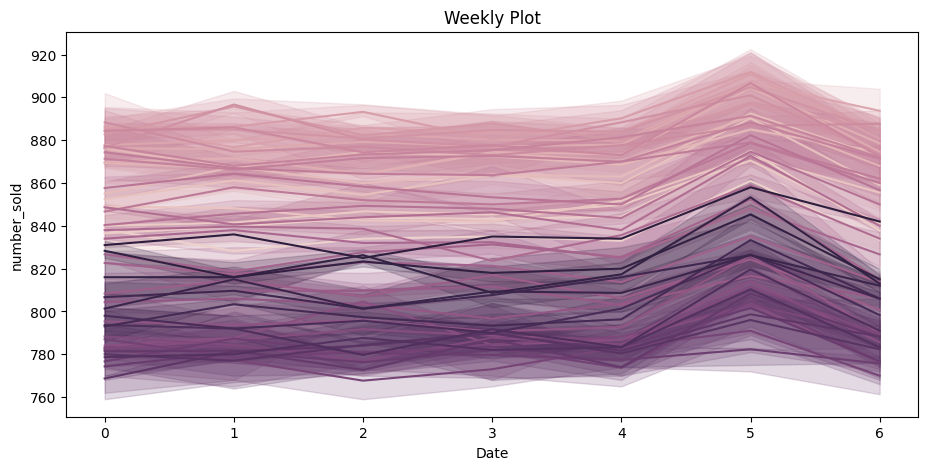

In [3]:
plt.figure(figsize=(11, 5))
sns.lineplot(x=df.index.dayofweek, y=df["number_sold"], hue=df.index.isocalendar().week.astype(int), legend=False)
plt.title("Weekly Plot")

# Daten aufteilen

In [4]:
df.index.year < 2015

array([ True,  True,  True, ..., False, False, False])

In [5]:
df_train = df[df.index.year < 2015]
df_test = df[df.index.year >= 2015]

In [6]:
df_train

,number_sold
Date,
2013-01-01,841
2013-01-02,838
2013-01-03,840
2013-01-04,822
2013-01-05,871
...,...
2014-12-27,838
2014-12-28,812
2014-12-29,842


In [7]:
df_test

,number_sold
Date,
2015-01-01,838
2015-01-02,831
2015-01-03,839
2015-01-04,828
2015-01-05,830
...,...
2016-04-14,881
2016-04-15,877
2016-04-16,895


# Besten Wert für *'order'* bestimmen

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
import numpy as np

def best_order_cv(orders, y_train):
    best_order = None
    best_score = float('inf')

    for order in orders:
        fourier = CalendarFourier(freq="Y", order=order)
        dp = DeterministicProcess(index=y_train.index, seasonal=True, additional_terms=[fourier])
        X_train = dp.in_sample()
        model = LinearRegression()
        scores = cross_val_score(model, X_train, y_train, cv=4, scoring="neg_mean_absolute_error")
        mean_score = -np.mean(scores)

        if mean_score < best_score:
            best_order = order
            best_score = mean_score

    return best_order

In [9]:
result = best_order_cv([1, 2, 3], df_train["number_sold"])
print("The best order is: ", result)

The best order is:  1


# Features generieren

In [10]:
fourier = CalendarFourier(freq="Y", order=1)
dp = DeterministicProcess(index=df.index, seasonal=True, additional_terms=[fourier])

X = dp.in_sample()
X

,"s(1,7)","s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)"
Date,,,,,,,,,
2013-01-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000
2013-01-02,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.017213,0.999852
2013-01-03,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.034422,0.999407
2013-01-04,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.051620,0.998667
2013-01-05,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.068802,0.997630
...,...,...,...,...,...,...,...,...,...
2016-04-14,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.977064,-0.212947
2016-04-15,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.973264,-0.229688
2016-04-16,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.969178,-0.246361


In [11]:
df_train.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2014-12-22', '2014-12-23', '2014-12-24', '2014-12-25',
               '2014-12-26', '2014-12-27', '2014-12-28', '2014-12-29',
               '2014-12-30', '2014-12-31'],
              dtype='datetime64[ns]', name='Date', length=730, freq='D')

In [12]:
X_train = X.loc[df_train.index]
X_train

,"s(1,7)","s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)"
Date,,,,,,,,,
2013-01-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000
2013-01-02,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.017213,0.999852
2013-01-03,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.034422,0.999407
2013-01-04,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.051620,0.998667
2013-01-05,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.068802,0.997630
...,...,...,...,...,...,...,...,...,...
2014-12-27,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.085965,0.996298
2014-12-28,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.068802,0.997630
2014-12-29,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.051620,0.998667


In [13]:
y_train = df_train["number_sold"]
y_train

Date
2013-01-01    841
2013-01-02    838
2013-01-03    840
2013-01-04    822
2013-01-05    871
             ... 
2014-12-27    838
2014-12-28    812
2014-12-29    842
2014-12-30    828
2014-12-31    836
Freq: D, Name: number_sold, Length: 730, dtype: int64

In [14]:
X_test = X.loc[df_test.index]
X_test

,"s(1,7)","s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)"
Date,,,,,,,,,
2015-01-01,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,1.000000
2015-01-02,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.017213,0.999852
2015-01-03,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.034422,0.999407
2015-01-04,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.051620,0.998667
2015-01-05,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.068802,0.997630
...,...,...,...,...,...,...,...,...,...
2016-04-14,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.977064,-0.212947
2016-04-15,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.973264,-0.229688
2016-04-16,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.969178,-0.246361


In [15]:
y_test = df_test["number_sold"]
y_test

Date
2015-01-01    838
2015-01-02    831
2015-01-03    839
2015-01-04    828
2015-01-05    830
             ... 
2016-04-14    881
2016-04-15    877
2016-04-16    895
2016-04-17    888
2016-04-18    881
Freq: D, Name: number_sold, Length: 474, dtype: int64

# Modell trainieren

In [16]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

# Modell visualisieren

In [17]:
train_predictions = model.predict(X_train)

<Axes: xlabel='Date', ylabel='number_sold'>

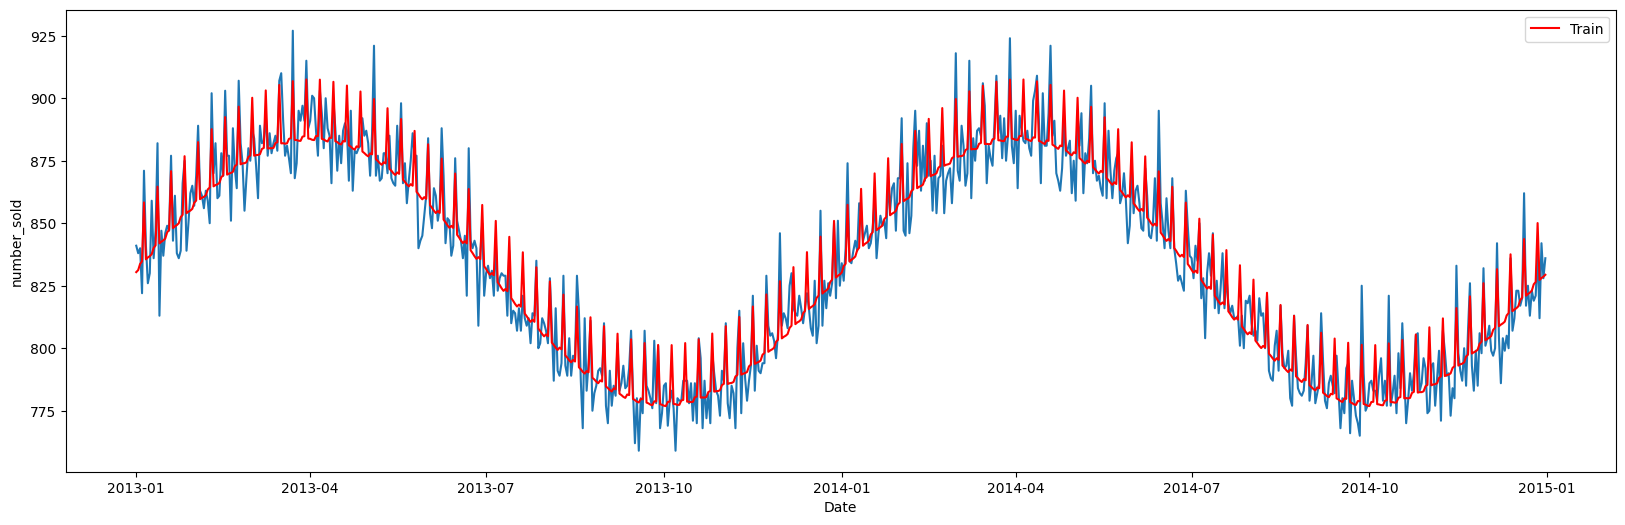

In [18]:
plt.figure(figsize=(20, 6))
sns.lineplot(x=X_train.index, y=y_train)
sns.lineplot(x=X_train.index, y=train_predictions, color="red", label="Train")

# Vorhersage auf den Testdaten

In [19]:
X_test

,"s(1,7)","s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)"
Date,,,,,,,,,
2015-01-01,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,1.000000
2015-01-02,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.017213,0.999852
2015-01-03,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.034422,0.999407
2015-01-04,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.051620,0.998667
2015-01-05,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.068802,0.997630
...,...,...,...,...,...,...,...,...,...
2016-04-14,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.977064,-0.212947
2016-04-15,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.973264,-0.229688
2016-04-16,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.969178,-0.246361


In [20]:
test_predictions = model.predict(X_test)

# Modellbewertung

In [21]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(test_predictions, y_test)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 7.784941983122363


<Axes: xlabel='Date', ylabel='number_sold'>

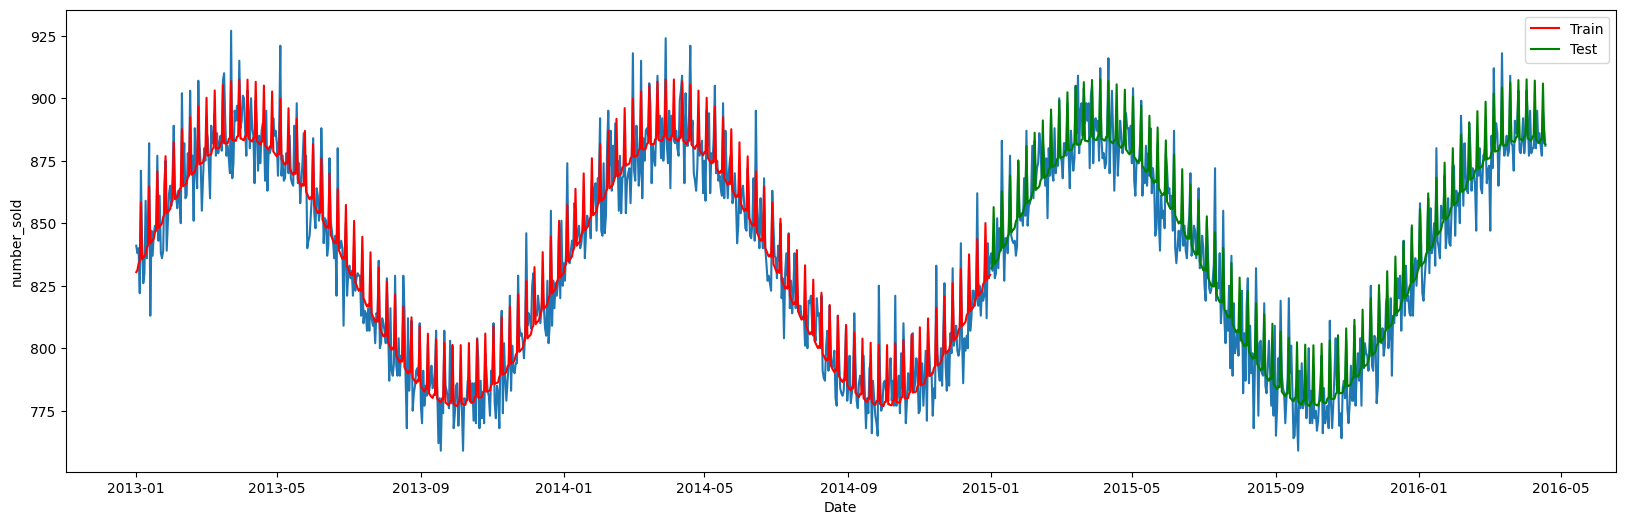

In [22]:
plt.figure(figsize=(20, 6))
sns.lineplot(x=df.index, y=df["number_sold"])
sns.lineplot(x=X_train.index, y=train_predictions, color="red", label="Train")
sns.lineplot(x=X_test.index, y=test_predictions, color="green", label="Test")

# Prognosen für das nächste Jahr:

In [23]:
X_forecast = dp.out_of_sample(steps=365)
X_forecast

,"s(1,7)","s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)"
2016-04-19,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.955211,-0.295927
2016-04-20,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.949990,-0.312281
2016-04-21,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.944489,-0.328542
2016-04-22,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.938710,-0.344707
2016-04-23,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.932655,-0.360771
...,...,...,...,...,...,...,...,...,...
2017-04-14,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.979614,-0.200891
2017-04-15,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.976011,-0.217723
2017-04-16,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.972118,-0.234491
2017-04-17,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.967938,-0.251190


In [24]:
forecast_predictions = model.predict(X_forecast)

<Axes: xlabel='Date', ylabel='number_sold'>

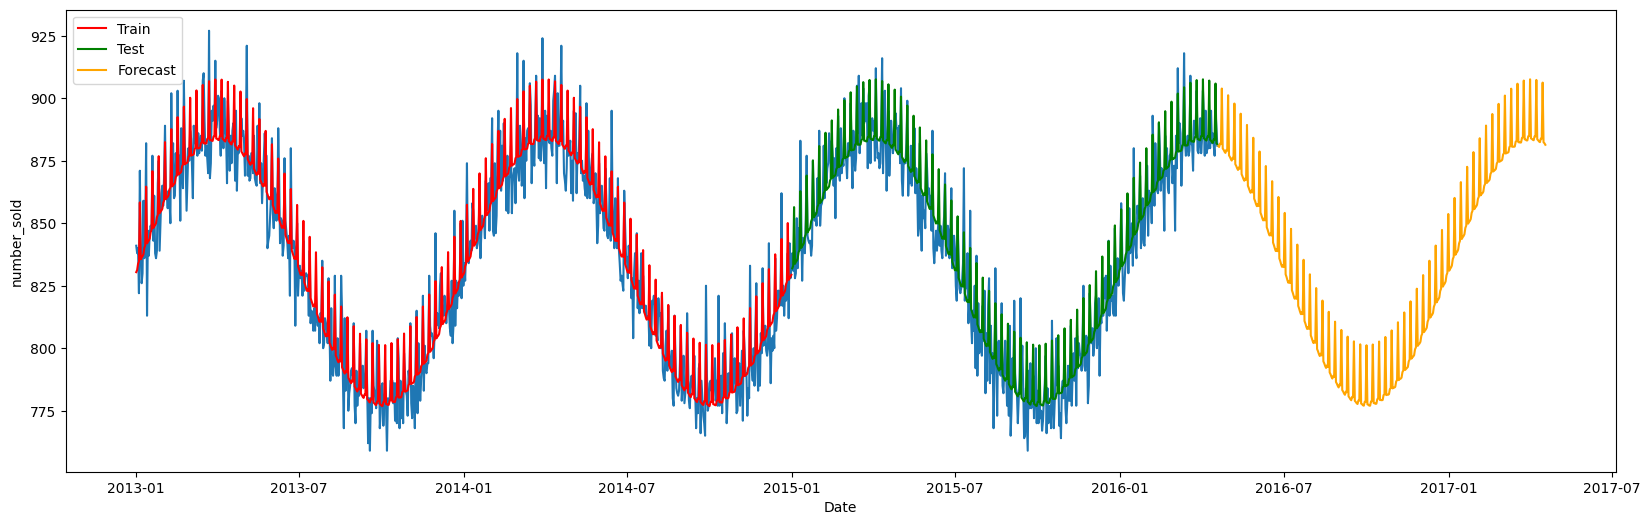

In [25]:
plt.figure(figsize=(20, 6))
sns.lineplot(x=df.index, y=df["number_sold"])
sns.lineplot(x=X_train.index, y=train_predictions, color="red", label="Train")
sns.lineplot(x=X_test.index, y=test_predictions, color="green", label="Test")
sns.lineplot(x=X_forecast.index, y=forecast_predictions, color="orange", label="Forecast")